In [72]:
import os
import h5py
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import svm
import plot_confusion_matrix as pcm
import matplotlib.pylab as plt
import scipy.stats as st
from scipy.fftpack import fft, fftfreq 
from scipy.signal import argrelextrema
import operator
from sklearn.metrics import ConfusionMatrixDisplay

print("Finished importing")


Finished importing


In [64]:
# Data preprocessing - making sure that each of the files has a 0 or 1 corresponding 
# to whether or not we have a bns or a nsbh or not.

bns = h5py.File('comb1_bns.hdf5','r')
nsb = h5py.File('comb5_nsbh.hdf5','r')

eos = 'APR4'
band = 'mAB_R'
show_plots = False

# Gets the specific EOS and band from the bns and nsb files
bns_eos_band = bns[eos][band][0:439] # shape -> (439, 400)
nsb_eos_band = nsb[eos][band] # shape -> (439, 400)
time_band = bns[eos]['time'] # shape -> (400,)

# Converts all of the arrays into numpy arrays
bns_eos_band = np.array(bns_eos_band)
nsb_eos_band = np.array(nsb_eos_band)
time_band = np.array(time_band)

# Creates all of the bns/nsb labels, in the form of a 0 or 1
bns_label = np.zeros(len(bns_eos_band))
nsb_label = np.ones(len(nsb_eos_band))

# A plot of both the BNS and NSBH light curves
if show_plots:
    for i in tqdm(range(len(bns_eos_band))):
        plt.plot(time_band / (24 * 3600), bns_eos_band[i], 'r-')
    
    plt.gca().invert_yaxis()
    plt.xlabel("Time (Days)")
    plt.ylabel("Brightness (mAB)")
    plt.title("Light Curve for BNS")
    plt.show()
    
    for i in tqdm(range(len(nsb_eos_band))):
        plt.plot(time_band / (24 * 3600), nsb_eos_band[i], 'b-')
    
    plt.gca().invert_yaxis()
    plt.xlabel("Time (Days)")
    plt.ylabel("Brightness (mAB)")
    plt.title("Light Curve for NSBH")
    plt.show()

all_data = np.concatenate([bns_eos_band, nsb_eos_band], axis=0)
all_labels = np.concatenate([bns_label, nsb_label], axis=0)

X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.2, random_state=42)
label_names = ["BNS", "NSB"]

print()
print("Finished pre-processing the data")



Finished pre-processing the data


In [65]:
def stat_area_features(x, Te=1.0):
    mean_ts = np.mean(x, axis=1).reshape(-1,1) # mean
    max_ts = np.amax(x, axis=1).reshape(-1,1) # max
    min_ts = np.amin(x, axis=1).reshape(-1,1) # min
    std_ts = np.std(x, axis=1).reshape(-1,1) # std
    skew_ts = st.skew(x, axis=1).reshape(-1,1) # skew
    kurtosis_ts = st.kurtosis(x, axis=1).reshape(-1,1) # kurtosis 
    iqr_ts = st.iqr(x, axis=1).reshape(-1,1) # interquartile rante
    mad_ts = np.median(np.sort(abs(x - np.median(x, axis=1).reshape(-1,1)),
                               axis=1), axis=1).reshape(-1,1) # median absolute deviation
    area_ts = np.trapz(x, axis=1, dx=Te).reshape(-1,1) # area under curve
    sq_area_ts = np.trapz(x ** 2, axis=1, dx=Te).reshape(-1,1) # area under curve ** 2

    return np.concatenate((mean_ts,max_ts,min_ts,std_ts,skew_ts,kurtosis_ts,
                           iqr_ts,mad_ts,area_ts,sq_area_ts), axis=1)

def frequency_domain_features(x, Te=1.0):
    # As the DFT coefficients and their corresponding frequencies are symetrical arrays
    # with respect to the middle of the array we need to know if the number of readings 
    # in x is even or odd to then split the arrays...
    if x.shape[1]%2 == 0:
        N = int(x.shape[1]/2)
    else:
        N = int(x.shape[1]/2) - 1
    xf = np.repeat(fftfreq(x.shape[1],d=Te)[:N].reshape(1,-1), x.shape[0], axis=0) # frequencies
    dft = np.abs(fft(x, axis=1))[:,:N] # DFT coefficients   
    
    # statistical and area features
    dft_features = stat_area_features(dft, Te=1.0)
    # weighted mean frequency
    dft_weighted_mean_f = np.average(xf, axis=1, weights=dft).reshape(-1,1)
    # 5 first DFT coefficients 
    dft_first_coef = dft[:,:5]    
    # 5 first local maxima of DFT coefficients and their corresponding frequencies
    dft_max_coef = np.zeros((x.shape[0],5))
    dft_max_coef_f = np.zeros((x.shape[0],5))
    for row in range(x.shape[0]):
        # finds all local maximas indexes
        extrema_ind = argrelextrema(dft[row,:], np.greater, axis=0) 
        # makes a list of tuples (DFT_i, f_i) of all the local maxima
        # and keeps the 5 biggest...
        extrema_row = sorted([(dft[row,:][j],xf[row,j]) for j in extrema_ind[0]],
                             key=operator.itemgetter(0), reverse=True)[:5] 
        for i, ext in enumerate(extrema_row):
            dft_max_coef[row,i] = ext[0]
            dft_max_coef_f[row,i] = ext[1]    
    
    return np.concatenate((dft_features,dft_weighted_mean_f,dft_first_coef,
                           dft_max_coef,dft_max_coef_f), axis=1)

def make_feature_vector(x,Te=1.0):
    # Raw signals :  stat and area features
    features_xt = stat_area_features(x, Te=Te)
    
    # Jerk signals :  stat and area features
    features_xt_jerk = stat_area_features((x[:,1:]-x[:,:-1])/Te, Te=Te)
    
    # Raw signals : frequency domain features 
    features_xf = frequency_domain_features(x, Te=1/Te)
    
    # Jerk signals : frequency domain features 
    features_xf_jerk = frequency_domain_features((x[:,1:]-x[:,:-1])/Te, Te=1/Te)
        
    return np.concatenate((features_xt,
                           features_xt_jerk,
                           features_xf,
                           features_xf_jerk), axis=1)


In [76]:
X_train = make_feature_vector(X_train, Te=1/50)
X_test = make_feature_vector(X_test, Te=1/50)

print("X_train shape : {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))

X_train shape : (702, 72)
X_test shape: (176, 72)


In [80]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test)

Hyperparameters optimization results:
C: 0.1
gamma: 0.1


Training set report
              precision    recall  f1-score   support

         BNS       1.00      0.99      1.00       353
         NSB       0.99      1.00      1.00       349

    accuracy                           1.00       702
   macro avg       1.00      1.00      1.00       702
weighted avg       1.00      1.00      1.00       702

Test set report
              precision    recall  f1-score   support

         BNS       1.00      1.00      1.00        86
         NSB       1.00      1.00      1.00        90

    accuracy                           1.00       176
   macro avg       1.00      1.00      1.00       176
weighted avg       1.00      1.00      1.00       176



<Figure size 640x480 with 0 Axes>

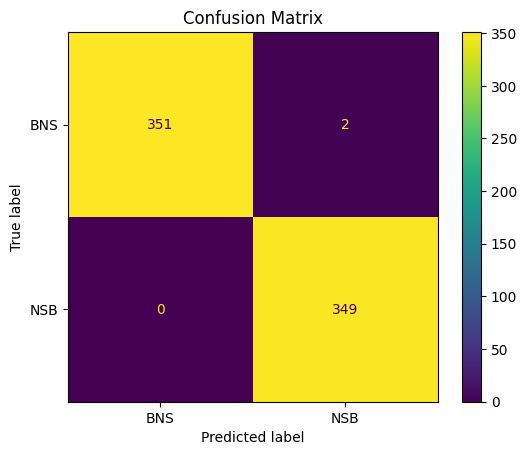

<Figure size 640x480 with 0 Axes>

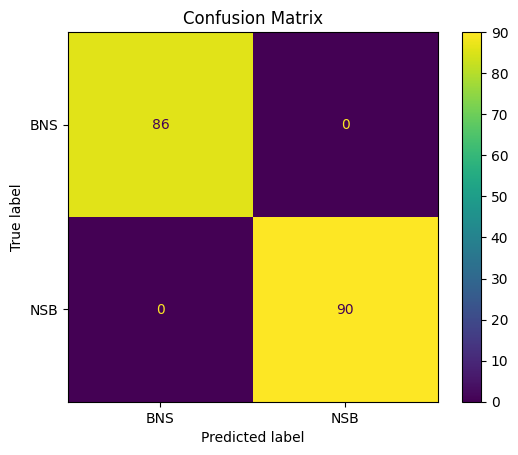

In [81]:
def hyperparameters_opt_RBF(X_train, y_train, X_test, y_test, param_range_C, param_range_gamma):
    accuracy_matrix = np.zeros((param_range_C.shape[0],param_range_gamma.shape[0]))
    for i,C in enumerate(param_range_C):
        for j,gamma in enumerate(param_range_gamma):
            clf_r_l = svm.SVC(kernel='rbf', C=C, gamma=gamma)
            clf_r_l.fit(X_train, y_train)
            accuracy_matrix[i,j] = f1_score(y_test ,clf_r_l.predict(X_test), average='macro')
    C_ind, gamma_ind = np.unravel_index(np.argmax(accuracy_matrix), accuracy_matrix.shape)

    return param_range_C[C_ind], param_range_gamma[gamma_ind]

# C and gamma test range
param_range = np.array([0.01, 0.1, 1, 10, 100, 1000])
# Optimizing C and gamma parameters to achieve the best f1 score 
C, gamma = hyperparameters_opt_RBF(X_train, y_train, X_test, y_test, param_range, param_range)

print("Hyperparameters optimization results:")
print("C: {}".format(C))
print("gamma: {}".format(gamma))
print("\n")

# Training the model with the optimized hyperparameters
clf_r_l = svm.SVC(kernel='rbf', C=C, gamma=gamma)
clf_r_l.fit(X_train, y_train)
y_pred_tr = clf_r_l.predict(X_train)
y_pred_te = clf_r_l.predict(X_test)

print('Training set report')
print(classification_report(y_train, y_pred_tr, target_names=label_names))
print('Test set report')
print(classification_report(y_test, y_pred_te, target_names=label_names))

plt.figure(1)
cm = confusion_matrix(y_train, y_pred_tr)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names).plot()
plt.title("Confusion Matrix")
plt.show()

plt.figure(2)
cm = confusion_matrix(y_test, y_pred_te)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names).plot()
plt.title("Confusion Matrix")
plt.show()

#plt.show()

In [74]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf_r_l, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {scores}")
print(f"Mean accuracy: {scores.mean()}")

Cross-validation scores: [1. 1. 1. 1. 1.]
Mean accuracy: 1.0


In [83]:
import numpy as np

X_train_noisy = X_train + np.random.normal(0, 0.01, X_train.shape)
noisy_scores = cross_val_score(clf_r_l, X_train_noisy, y_train, cv=5, scoring='f1_macro')
print("Cross-validation F1 Scores with Noise:", noisy_scores)

Cross-validation F1 Scores with Noise: [0.98581489 0.97871912 1.         0.98571137 0.98571137]
